# Detección de reseñas positivas y negativas de una tienda de ropa usando XLM-RoBERTa (base-sized model)


En este proyecto, vamos a aplicar técnicas avanzadas de procesamiento del lenguaje natural (NLP) utilizando BERT (Bidirectional Encoder Representations from Transformers) para analizar y clasificar reseñas de clientes de una tienda de ropa como positivas o negativas. Utilizaremos un conjunto de datos que contiene reseñas etiquetadas previamente para entrenar y evaluar nuestro modelo.

### RoBERTa
El transformador RoBERTa es un modelo de lenguaje natural pre-entrenado basado en la arquitectura de los transformers. Fue desarrollado por Facebook AI Research (FAIR) y es una versión optimizada del modelo BERT de Google, con una arquitectura más grande y mejoras en el proceso de entrenamiento.

RoBERTa posee un enfoque de pre-entrenamiento no supervisado para el aprendizaje de representaciones de alta calidad del lenguaje natural. Esto se consigue mediante la tarea de "llenado de huecos" en el corpus de entrenamiento, donde el modelo debe predecir la palabra restante en una oración determinada.

Tras el pre-entreno del modelo, se puede hacer uso para una variedad de tareas de procesamiento de lenguaje natural, como la clasificación de sentimientos, la generación de texto y la traducción de idiomas. El rendimiento que ha demostrado RoBERTa ha sido muy bueno en muchas de estas tareas y es uno de los modelos de lenguaje natural pre-entrenados más usados hoy en día.


### Problema a resolver
- **PROBLEMA**: _Debido a las altas devoluciones que se están produciendo en una tienda de ropa local, se necesita reducir el número de éstas para poder yo como dueño de la tienda ver cuales son las causas por los que el usuario devuelve la prenda. Así poder mejorar las caracteristicas de las prendas o qué tipo de ropa quieren los compradores que tenga en dicha tienda_


- **SOLUCIÓN**: La solución a lo anterior se basa en clasificar una opinión de una prenda en POSITIVA o NEGATIVA mediante el uso de técnicas de procesamiento de lenguaje natural y Deep Learning.

### Técnicas y métodos para la resolución del problema

- Uso de notebook en Google Colab para la utilización de su GPU.

- Uso de la librería transformers de [Hugging Face](https://huggingface.co/), eligiendo el modelo [xlm-roberta-base](https://huggingface.co/xlm-roberta-base) para realizar el procesamiento del texto y agregando dos capas neuronales para mejorar el rendimiento.

El modelo fue entrenado con lenguaje español utilizando el dataset de [Kaggle](https://www.kaggle.com/datasets/shavilyarajput/clothing-shoes-and-jewellery-reviews), que contiene varias reviews de productos de una tienda de ropa.

- Se utilizó la métrica de evaluación del modelo: Accuracy,  debido a que el equilibrio de la distribución de los ejemplos era bueno.


# Despliegue del modelo
Se ha elaborado una interfaz gráfica del modelo que se puede apreciar en el siguiente enlace --> https://reviewsiabigdata.streamlit.app/

# 1. Instalación de librerías necesarias

In [1]:
!pip install transformers datasets easynmt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 10.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.

# 2. Importación de librerias y modulos

In [2]:
from sklearn.model_selection import train_test_split  # Para dividir los datos en conjuntos de entrenamiento y prueba
from transformers import AdamW, get_linear_schedule_with_warmup, AutoTokenizer, AutoModelForMaskedLM, AutoModel
# Importaciones relacionadas con Transformers:
# - AdamW: Optimizador específico para modelos de Transformers que implementa la variante de Adam con corrección de pesos.
# - get_linear_schedule_with_warmup: Ayuda a ajustar la tasa de aprendizaje durante el entrenamiento.
# - AutoTokenizer: Permite cargar un tokenizador específico del modelo automáticamente.
# - AutoModelForMaskedLM: Modelo preentrenado para tareas de Masked Language Modeling (MLM).
# - AutoModel: Permite cargar un modelo preentrenado automáticamente según el nombre proporcionado.

import torch  # Biblioteca principal de PyTorch para aprendizaje profundo.
from torch import nn, optim  # Submódulos de PyTorch para redes neuronales y optimización.
from torch.utils.data import Dataset, DataLoader  # Funcionalidades para manejo de datos y carga eficiente.
import pandas as pd  # Librería para manipulación y análisis de datos tabulares.
from textwrap import wrap  # Utilidad para envolver texto en líneas de ancho fijo.
import math  # Funciones matemáticas estándar.
import numpy as np  # Biblioteca para soporte de matrices y operaciones numéricas eficientes.
import torch.nn.functional as F  # Funciones de activación y capas de PyTorch.
from easynmt import EasyNMT  # Biblioteca para fácil implementación de modelos de traducción automática.


In [4]:
#Debemos subir a Google el archivo: balanced_review.csv para proceder a leerlo posteriormente
df = pd.read_csv('balanced_review.csv', delimiter=",", quotechar='"')

In [ ]:
print(f"Total rows: {len(df)}")


Total rows: 792000


# 3. Procesamiento de dataset

In [5]:
# Se inicializa
np.random.seed(42) # Elijo semilla
torch.manual_seed(42)

# Activo GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:

# Dividir el dataset en entrenamiento y resto (validación + prueba)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# Dividir el resto en validación y prueba
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train set: {len(train_df)} rows")
print(f"Validation set: {len(val_df)} rows")
print(f"Test set: {len(test_df)} rows")

# Guardar los subconjuntos en archivos CSV
train_df.to_csv('train.csv', index=False)
val_df.to_csv('validation.csv', index=False)
test_df.to_csv('test.csv', index=False)

print("Datasets guardados en archivos CSV.")

Train set: 210718 rows
Validation set: 45154 rows
Test set: 45154 rows
Datasets guardados en archivos CSV.


In [8]:
# Cargar los archivos CSV en DataFrames de pandas
df_train = pd.read_csv('train.csv')
df_validation = pd.read_csv('validation.csv')
df_test = pd.read_csv('test.csv')

In [9]:
# Filtro para no tener ejemplos de 3 calificaciones ya que las voy a considerar neutros
df_train = df_train[df_train['overall'] != 3]

In [10]:
# Categorizo en una variable
# 1 o 2 calificaciones = 0
# 4 o 5 calificaciones = 1
def merge_star_ratings(row):
    if row['overall'] <= 2:
        label = 0
    else:
        label = 1
    return label

# Aplico la función de categorización a cada fila del DataFrame
df_train['labels'] = df_train.apply(merge_star_ratings, axis=1)
df_validation['labels'] = df_validation.apply(merge_star_ratings, axis=1)
df_test['labels'] = df_test.apply(merge_star_ratings, axis=1)

# Muestra de 5000 ejemplos para el conjunto de entrenamiento
df_train = df_train.sample(n=5000, random_state=42)

# Utilizamos df_train, df_validation y df_test como nuestro conjunto de datos
tienda_train = df_train.copy()
tienda_val = df_validation.copy()
tienda_test = df_test.copy()


In [11]:
# Visualizamos el tamaño de cada muestra
print(f"Train: {tienda_train.shape[0]}, Val: {tienda_val.shape[0]}, Test: {tienda_test.shape[0]}")

Train: 5000, Val: 45154, Test: 45154


In [12]:
# Visualizamos que la distribucion es equilibrada
tienda_train.labels.value_counts()

labels
1    2542
0    2458
Name: count, dtype: int64

In [13]:
# Tamaños de las muestras
print(f"Train: {tienda_train.shape[0]}, Val: {tienda_val.shape[0]}, Test: {tienda_test.shape[0]}")

Train: 5000, Val: 45154, Test: 45154


In [14]:
# Observo que la distribucion es equilibrada
tienda_train.labels.value_counts()

labels
1    2542
0    2458
Name: count, dtype: int64

# 4. Tokenización del texto  

In [15]:
# Se carga el modelo para tokenizar el texto

model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

# 5. Dataset y DataLoader

In [16]:
# Creamos nuestra clase Dataset

class TiendaDataset(Dataset):

  def __init__(self,reviews,labels,tokenizer,max_len : int= 250):
    self.reviews = reviews # Texto
    self.labels = labels # Etiquetas
    self.tokenizer = tokenizer # Tokenizer
    self.max_len = max_len #maximo de longitud de texto 250 caracteres

  def __len__(self):
      return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item]) # Iterador
    label = self.labels[item]
    encoding = tokenizer.encode_plus(
        review,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        padding = "max_length",
        return_attention_mask = True,
        return_tensors = 'pt'
        )


    return {
          'review': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      }



In [17]:
# Creo funcion Dataloader

def Tienda_data_loader(df, tokenizer, max_len : int= 250, batch_size : int= 16):
  dataset = TiendaDataset(
      reviews = df.reviewText.to_numpy(),
      labels = df.labels.to_numpy(),
      tokenizer = tokenizer
  )

  return DataLoader(dataset, batch_size, num_workers = 4)

In [18]:
# Instancio los DataLoaders

train_data_loader = Tienda_data_loader(tienda_train, tokenizer)
val_data_loader = Tienda_data_loader(tienda_val, tokenizer)
test_data_loader = Tienda_data_loader(tienda_test, tokenizer)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# 6. Modelo - RoBERTa

In [19]:
# Se crea el modelo

class RobertaModel(nn.Module):

  def __init__(self, n_classes: int = 2):
    super().__init__()
    self.roberta = AutoModel.from_pretrained("xlm-roberta-base") # Transformer
    self.dropout = nn.Dropout(p=0.3) #Añadimos un Dropout para disminuir el overfitting
    self.linear = nn.Linear(self.roberta.config.hidden_size, self.roberta.config.hidden_size) # 1er capa linear
    self.classification = nn.Linear(self.roberta.config.hidden_size, n_classes) # 2da capa linear

  def forward(self, input_ids, attention_mask):
    #Roberta layer
    cls_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = torch.mean(cls_output.last_hidden_state, 1)


    # Red Nueronal
    pooled_output = self.linear(pooled_output) # Primera capa
    pooled_output = F.relu(pooled_output) # Funcion de activacion relu
    pooled_output = self.dropout(pooled_output) # Dropout
    output = self.classification(pooled_output) #Segunda capa

    return output




In [20]:
# Instancio modelo
model = RobertaModel().to(device)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

# 7. Optimizacion modelo

In [21]:
# Optimizacion y parametros de entrenamiento
EPOCHS = 5
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.001)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = math.floor(total_steps * 0.2),
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

# 8. Loops de Train y Evaluacion

In [22]:
# Defino funcion de loop de Train

def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids, attention_mask)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double()/n_examples, np.mean(losses)

# Defino funcion de loop de Evaluacion

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids, attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double()/n_examples, np.mean(losses)

# 9. Train y Validacion

In [23]:
from tqdm import tqdm

results = {"train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [] }


for epoch in tqdm(range(EPOCHS), desc='Epochs', unit='epoch'):
    train_acc, train_loss = train_model(
        model, train_data_loader, loss_fn, optimizer, device, scheduler, len(tienda_train)
    )
    val_acc, val_loss = eval_model(
        model, val_data_loader, loss_fn, device, len(tienda_val)
    )
    print('Entrenamiento: Loss: {}, accuracy: {}'.format(train_loss, train_acc))
    print('Validación: Loss: {}, accuracy: {}'.format(val_loss, val_acc))
    print('')

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc.cpu())
    results["val_loss"].append(val_loss)
    results["val_acc"].append(val_acc.cpu())

Epochs:   0%|          | 0/5 [00:00<?, ?epoch/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epochs:  20%|██        | 1/5 [15:41<1:02:44, 941.00s/epoch]

Entrenamiento: Loss: 0.4689462394022142, accuracy: 0.7576
Validación: Loss: 0.4634085190114593, accuracy: 0.7695663728573326



Epochs:  40%|████      | 2/5 [31:24<47:07, 942.62s/epoch]  

Entrenamiento: Loss: 0.2630120871793895, accuracy: 0.9138000000000001
Validación: Loss: 0.8423491986992984, accuracy: 0.7357044780085928



Epochs:  60%|██████    | 3/5 [47:09<31:26, 943.44s/epoch]

Entrenamiento: Loss: 0.18927556060674117, accuracy: 0.9486
Validación: Loss: 1.0474362928315395, accuracy: 0.7425920184258316



Epochs:  80%|████████  | 4/5 [1:02:53<15:43, 943.65s/epoch]

Entrenamiento: Loss: 0.13778064295592996, accuracy: 0.9658
Validación: Loss: 1.2607324216488847, accuracy: 0.7520706914116135



Epochs: 100%|██████████| 5/5 [1:18:36<00:00, 943.38s/epoch]

Entrenamiento: Loss: 0.10023780107779351, accuracy: 0.9758
Validación: Loss: 1.337724739716542, accuracy: 0.7499667803516853



Podemos observar un valor de Accuracy mayor al 90% en la fase de Train y Validación, con un valor de Loss muy bajo.
Por tanto, existe un gran rendiemiento del modelo

# 10. Gráfico de Loss y Accuracy

In [24]:
# Creo funciones

import matplotlib.pyplot as plt

def plot_loss(train_loss, val_loss):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("Loss - Train vs Val")
    ax.plot(train_loss, label="Loss Train")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax2 = ax.twinx()
    ax2.plot(val_loss, label="Loss Val", color="orange")
    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")
    ax.grid(True)
    plt.show()

def plot_accuracy(train_acc, val_acc):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("Accuracy - Train vs Val")
    ax.plot(train_acc, label="Accuracy Train")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax2 = ax.twinx()
    ax2.plot(val_acc, label="Accuracy Val", color="orange")
    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")
    ax.grid(True)
    plt.show()

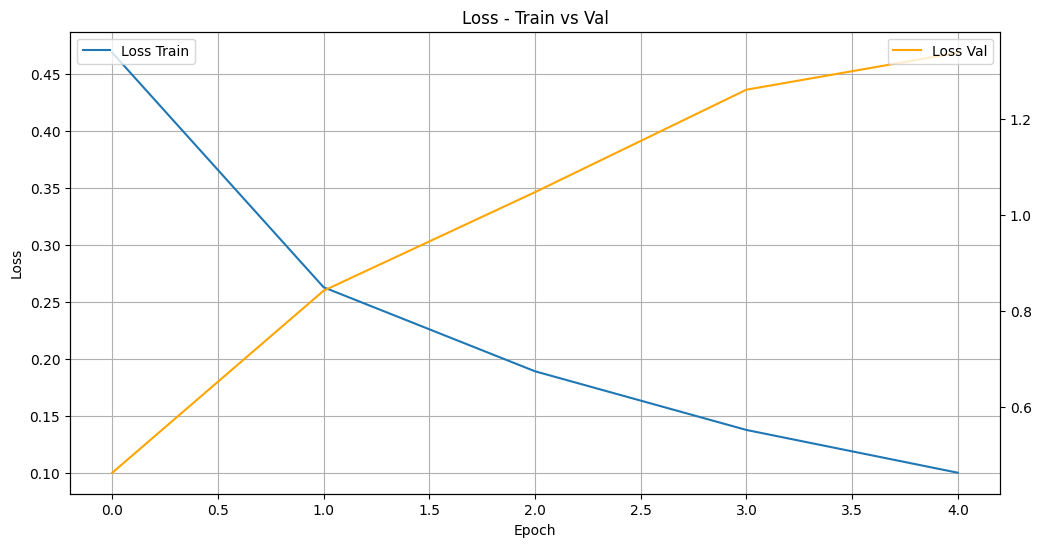

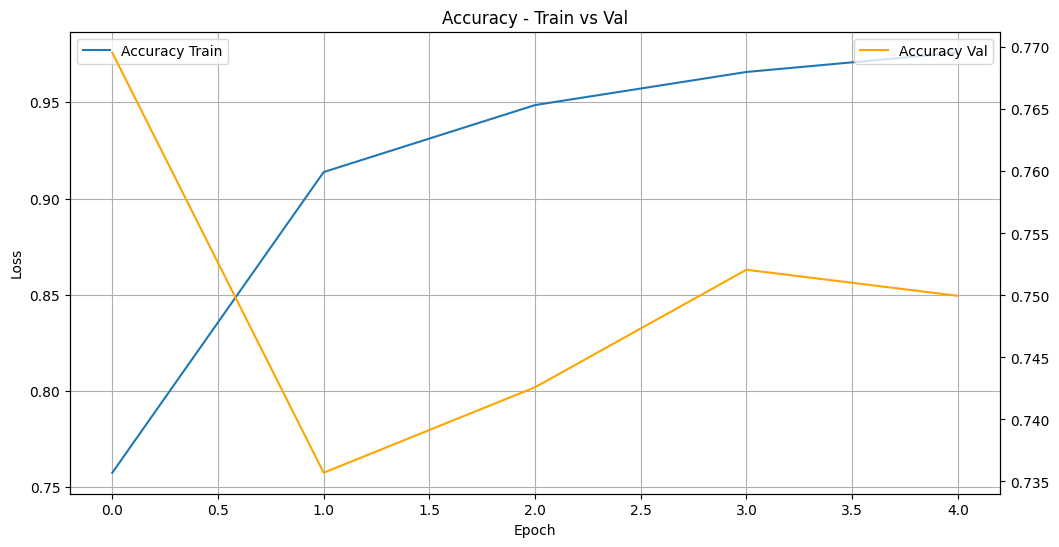

In [25]:
plot_loss(results["train_loss"], results["val_loss"])
plot_accuracy(results["train_acc"], results["val_acc"])

**Loss:** En la época 2, se observa la menor pérdida en el conjunto de validación, después de lo cual comienza a aumentar, aunque siempre se mantiene en un nivel muy bajo.

**Accuracy:** Se nota un aumento en la exactitud para ambos conjuntos (entrenamiento y validación), alcanzando valores superiores al 90%. No se detecta sobreajuste.

# 11. Evaluacion de Test

In [26]:
test_acc, test_loss = eval_model(
    model, test_data_loader, loss_fn, device, len(tienda_test))

print('Test: Loss: {}, accuracy: {}'.format(test_loss, test_acc))

Test: Loss: 1.3318009777919146, accuracy: 0.7519821056827745


Se observa un gran rendimiento (Accuracy mayor a 90%) en el conjunto de Test

# 12. Guardar el modelo

Se guarda en el inicio de Google Drive

In [27]:
# Dar permisos para guardar en el Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
# Guardo el modelo

PATH = "/content/drive/My Drive/Modelo_Tienda_review.pt"

torch.save(model.state_dict(), PATH)

# 13. Evaluacion con texto propio

In [29]:
# Creamos una función personalizada para una determinada reseña y detectar si es positiva o negativa

def ClasificacionSentimiento(review_text):
    encoding_review = tokenizer.encode_plus(
        review_text,
        max_length = 250,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        padding = "max_length",
        return_attention_mask = True,
        return_tensors = 'pt'
        )

    input_ids = encoding_review['input_ids'].to(device)
    attention_mask = encoding_review['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    print("\n".join(wrap(review_text)))
    print(prediction)
    if prediction == 0:
        print('La reseña es negativa')
    else:
        print('La reseña es positiva')




In [30]:
# Llamamos a la función de clasificación

text = "Para el precio que costaba, la camiseta no era muy bonita"
ClasificacionSentimiento(text)

Para el precio que costaba, la camiseta no era muy bonita
tensor([0], device='cuda:0')
La reseña es negativa


# 14. Conclusión

El modelo ha demostrado un rendimiento bastante bueno en los tres conjuntos de datos del dataset, alcanzando una precisión (Accuracy) superior al 90%.


Se desarrolló una interfaz gráfica para facilitar el uso del modelo: https://reviewsiabigdata.streamlit.app/
